## <center> Monthly TOD MEF Comparisons </center> 

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
from IPython.display import display
from IPython.core.debugger import set_trace
import calendar

In [2]:
LABELS = ['so2_kg', 'nox_kg', 'pm25_kg', 'co2_kg', 'so2_dam_ap2', 'nox_dam_ap2',
       'pm25_dam_ap2', 'so2_dam_eas', 'nox_dam_eas', 'pm25_dam_eas',
       'co2_dam']
LABELS.sort()
LABELS_FULL = LABELS + ['dam_eas', 'dam_ap2']
dam_cols_ap2 = ['co2_dam', 'so2_dam_ap2', 'nox_dam_ap2', 'pm25_dam_ap2']
dam_cols_eas = ['co2_dam', 'so2_dam_eas', 'nox_dam_eas', 'pm25_dam_eas']

In [3]:
GROUPING_NAMES = ['SeasonalTOD', 'MonthTOD', 'TOD', 'YearOnly', 'Month']
GROUPING_COLS = [['year', 'season', 'hour'], ['year', 'month', 'hour'], 
        ['year', 'hour'], ['year'], ['year', 'month']]
GROUPING_NAMES_COLS = dict(zip(GROUPING_NAMES, GROUPING_COLS))

## Read in data

In [4]:
def get_factor_df(kind='MEF', time='MonthTOD', region='PJM', fuel_type='FossilOnly'):
    kind_folder = 'mefs' if kind=='MEF' else 'aefs'
    
    # Read in file
    if fuel_type == 'FossilOnly':
        region_breakdown = 'isorto' if region == 'PJM' else 'nerc'
        df = pd.read_csv(os.path.join(os.pardir, 'calculated_factors', kind_folder, time, 
                                      '{}_{}.csv'.format(region_breakdown, kind_folder)),
                         index_col=GROUPING_NAMES_COLS[time])
        df = df[df[region_breakdown] == region].drop(region_breakdown, axis=1)
    else:
        if region != 'PJM':
            raise NotImplementedError('fossil-plus factors are only available for PJM')
        df = pd.read_csv(os.path.join(os.pardir, 'calculated_factors', kind_folder, time, 
                                      'pjm_fplus_{}.csv'.format(kind_folder)),
                         index_col=GROUPING_NAMES_COLS[time])
        
    # Filter MEF columns
    if kind == 'MEF':
        df = df.drop([x for x in df.columns if '-r' in x or '-int' in x], axis=1)
        df.columns = [x.replace('-est', '') for x in df.columns]
        
    # Ensure columns have numeric type
    df = df.apply(pd.to_numeric, axis=1)
    
    return df

In [5]:
all_dfs = {}
for kind in ['MEF', 'AEF']:
    for region in ['PJM', 'RFC']:
        for fuel_type in ['FossilOnly', 'FossilPlus']:
            for time in ['MonthTOD']:
                if region == 'RFC' and fuel_type == 'FossilPlus': 
                    continue
                print(kind, region, fuel_type, time)
                df = get_factor_df(kind=kind, time=time, region=region, fuel_type=fuel_type)
                all_dfs[(kind, region, fuel_type, time)] = df
                print(df.index.get_level_values('year').unique().values)    

MEF PJM FossilOnly MonthTOD
[2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017]
MEF PJM FossilPlus MonthTOD
[2016 2017]
MEF RFC FossilOnly MonthTOD
[2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017]
AEF PJM FossilOnly MonthTOD
[2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017]
AEF PJM FossilPlus MonthTOD
[2016 2017]
AEF RFC FossilOnly MonthTOD
[2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017]


## Full plots for SI

In [6]:
FULL_DAMS = ['dam_ap2', 'dam_eas']
def format_title(label):
    l = label.split('_')
    if label in FULL_DAMS:
        t = 'Total damages ({})'.format('AP2' if l[1] == 'ap2' else 'EASIUR')
    else:
        t = '{0}$_{{{1}}}$ {2}'.format(l[0][:2].upper(), l[0][2:], 'emissions' if l[1] == 'kg' else 'damages')
        if len(l) > 2: t += ' ({})'.format('AP2' if l[2] == 'ap2' else 'EASIUR')
    return t

In [7]:
def month_tod_plot_helper(label, df_dict, ylim, year,
                     figsize, outer_dims, inner_dims, months_to_plot,
                     hspace, subtitle_break,
                     lgd_ncol, lgd_bbox_to_anchor, use_suptitle):
    fontsize=16
    fig = plt.figure(figsize=figsize)
    outer = gridspec.GridSpec(*outer_dims, wspace=-0.45, hspace=hspace)
    
    def get_month_only(df, month, year):
        df = df.reset_index().query('month=={}'.format(month)).query('year=={}'.format(year))
        df = df.drop(['year', 'month'], axis=1).set_index('hour')
        return df
    
    for i, month in enumerate(months_to_plot):
        inner = gridspec.GridSpecFromSubplotSpec(*inner_dims, subplot_spec=outer[i], wspace=0.1, hspace=0.1)
        for j, kind in enumerate([('PJM', 'FossilPlus'), ('PJM', 'FossilOnly'), ('RFC', 'FossilOnly')]):
            ax = plt.Subplot(fig, inner[j])
            fig.add_subplot(ax)
            ncol = outer_dims[1]
            
            # Plot average factors for this month
            avg = get_month_only(df_dict[('AEF',) + kind + ('MonthTOD',)], month, year)    
            avg[label].plot(ax=ax, marker='*', legend=False, label='Average',
                                  ls='--', markersize=5.5, color='green')
            
            # Plot marginal factors for this month
            marg = get_month_only(df_dict[('MEF',) + kind + ('MonthTOD',)], month, year)
            marg[label].plot(ax=ax, marker='o', legend=False, label='Marginal',
                        ls='-', markersize=3, color='blue',
                        yerr=marg['{}-se'.format(label)])
            
            # Set y limits
            ax.set_ylim(*ylim)
            
            # Add titles to plots (for both month and region/gen mix)
            #   For plots at top, indicate which region/gen mix
            if month in months_to_plot[:ncol]:
                ax.set_title('{}{}({}-{})\n\n'.format(
                    kind[0], subtitle_break, kind[1][:-4].lower(), kind[1][-4:].lower()), fontweight='bold')
            #  For plots in the middle, indicate which month (and deal with cases where
            #   we've already used the title attribute for region/gen mix labels)
            if j == 1:
                if month in months_to_plot[:ncol]:
                    ax.text(0.5,1.09, calendar.month_abbr[month],
                            horizontalalignment='center', verticalalignment='center', 
                            transform=ax.transAxes, fontsize=fontsize)
                else:
                    ax.set_title(calendar.month_abbr[month])
        
            # Add x-axis label to middle plots at bottom
            if month in months_to_plot[-ncol:] and j == 1:
                ax.set_xlabel('Hour of day (UTC-5)')
            else:
                ax.set_xlabel('')
        
            # Add y-axis label on left column only, and y-axis ticks on left plots within each month
            if (i % ncol) == 0 and j == 0:
                ylabel = 'Damage factor\n(\$/MWh)' if 'dam' in label else 'Emissions factor\n(kg/MWh)'
                ax.set_ylabel(ylabel)
            if j > 0:
                ax.set_yticklabels([])
            
            # Set larger font size
            for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                         ax.get_xticklabels() + ax.get_yticklabels()):
                item.set_fontsize(fontsize)

            # Add legend at bottom (to last plot)
            if i == len(months_to_plot)-1 and j == 2:
                lgd = ax.legend(ncol=lgd_ncol, bbox_to_anchor=lgd_bbox_to_anchor, 
                                      loc='upper left', fontsize=fontsize)
                
    # Overall title for plot 
    if use_suptitle:
        sup = plt.suptitle('{} ({})'.format(format_title(label), year),  x=0.375, y=0.97,
                           fontsize=fontsize, fontweight='bold', fontstyle='italic')
    
#     if not os.path.exists(os.path.join('figures', 'month_tod')):
#         os.makedirs(os.path.join('figures', 'month_tod'))
#     fig.savefig(os.path.join('figures', 'month_tod','si-{}.pdf'.format(label)), 
#                 bbox_extra_artists=(lgd,sup), bbox_inches='tight')
                    
    return fig

In [8]:
def month_tod_si_plot(label, df_dict, ylim, year=2017):
    figsize=(22,16)
    outer_dims=(6,2)
    inner_dims=(1,6)
    months_to_plot=range(1,13)
    lgd_ncol = 2
    lgd_bbox_to_anchor=(-3.35, -0.35)
    use_suptitle=True
    hspace=0.4
    subtitle_break='\n'
    return month_tod_plot_helper(label, df_dict, ylim, year, 
                     figsize, outer_dims, inner_dims, months_to_plot,
                     hspace, subtitle_break, 
                     lgd_ncol, lgd_bbox_to_anchor, use_suptitle)

In [9]:
ylims_dict = dict([
    ['co2_kg', (0,900)], ['so2_kg', (0,3)], ['nox_kg', (0,1.3)], ['pm25_kg', (0,0.15)],
    ['co2_dam', (0,40)], ['so2_dam_eas', (0,100)], ['so2_dam_ap2', (0,120)],
    ['nox_dam_eas', (0,15)], ['nox_dam_ap2', (0,7)], 
    ['pm25_dam_eas', (0,15)], ['pm25_dam_ap2', (0,20)],
    ['dam_eas', (0,150)], ['dam_ap2', (0,150)]
])

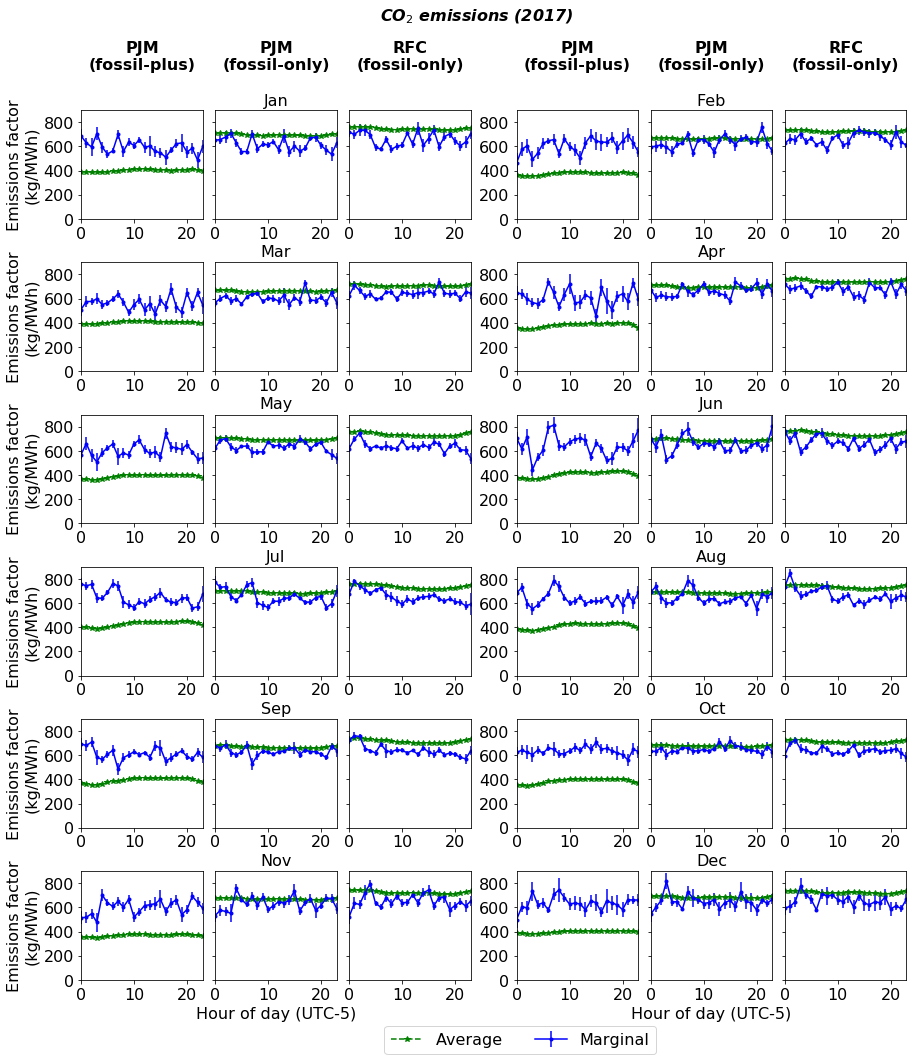

In [10]:
month_tod_si_plot('co2_kg', all_dfs, (0,900));

In [11]:
# for label, ylim in ylims_dict.items():
#     display(month_tod_si_plot(label, all_dfs, ylim))

In [12]:
def month_tod_paper_plot(label, df_dict, ylim, year=2017):
    figsize=(12,4)
    outer_dims=(2,1)
    inner_dims=(1,3)
    months_to_plot=[5,11]
    lgd_ncol=1
    lgd_bbox_to_anchor=(1.05, 1.6)
    use_suptitle=False
    hspace=0.5
    subtitle_break=' '
    return month_tod_plot_helper(label, df_dict, ylim, year, 
                     figsize, outer_dims, inner_dims, months_to_plot,
                     hspace, subtitle_break,
                    lgd_ncol, lgd_bbox_to_anchor, use_suptitle)

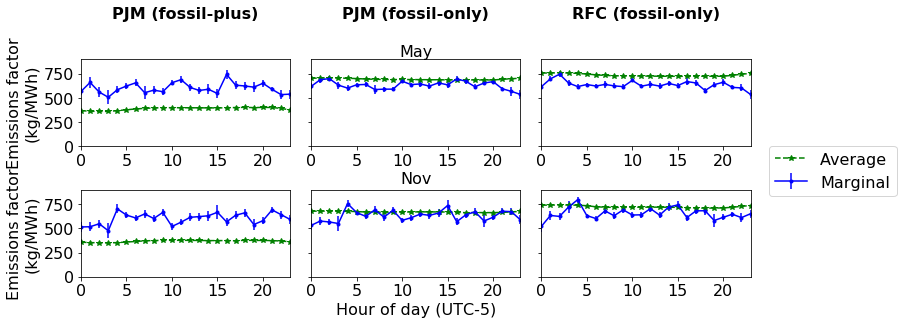

In [13]:
month_tod_paper_plot('co2_kg', all_dfs, (0,900));

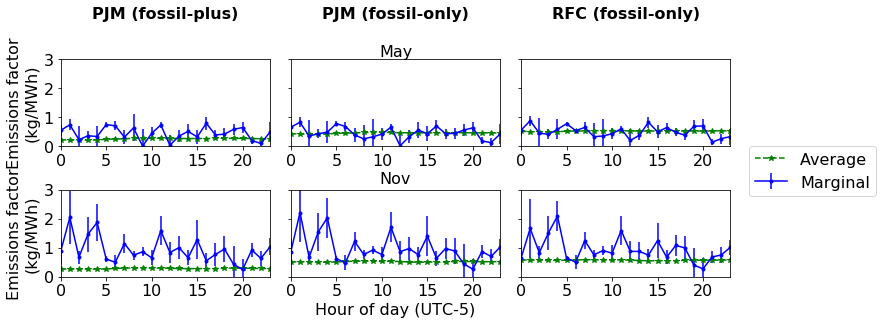

In [14]:
month_tod_paper_plot('so2_kg', all_dfs, (0,3));

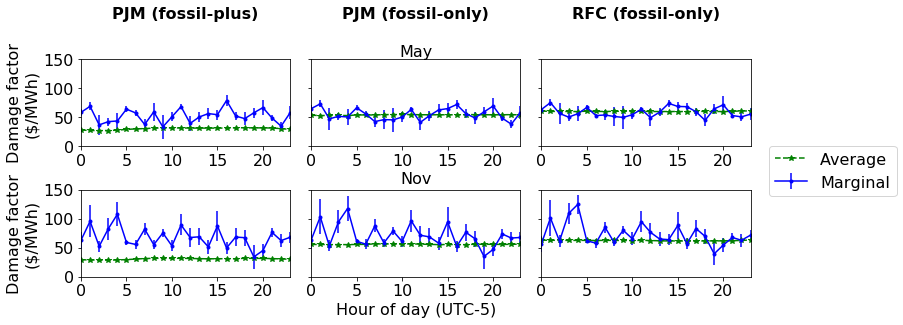

In [15]:
month_tod_paper_plot('dam_ap2', all_dfs, (0,150));

### Presentations

In [16]:
def pres_plot(df_dict, kind):
    fig, axes = plt.subplots(1, 2, figsize=(10, 1.5), sharey=True)
    fontsize=16
    label = 'dam_ap2'

    for i, month in enumerate([5,11]):
        ax = axes[i]

        def get_month_only(df, month, year):
                df = df.reset_index().query('month=={}'.format(month)).query('year=={}'.format(year))
                df = df.drop(['year', 'month'], axis=1).set_index('hour')
                return df
        
        # Plot average factors for this month
        avg = get_month_only(df_dict[('AEF',) + kind + ('MonthTOD',)], month, 2017)    
        avg[label].plot(ax=ax, marker='*', legend=False, label='Average',
                              ls='--', markersize=5.5, color='green')

        # Plot marginal factors for this month
        marg = get_month_only(df_dict[('MEF',) + kind + ('MonthTOD',)], month, 2017)
        marg[label].plot(ax=ax, marker='o', legend=False, label='Marginal',
                    ls='-', markersize=3, color='blue',
                    yerr=marg['{}-se'.format(label)])

        ax.set_ylim(0, 150)
        ax.set_xlabel('Hour of day (UTC-5)')
        ax.set_ylabel('Damage factor\n(\$/MWh)')

        ax.set_title(calendar.month_name[month])

        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                     ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(fontsize)
    
#     fig.savefig(os.path.join('figures', 'month_tod','presentation', '{}.pdf'.format(ftype)), bbox_inches='tight')

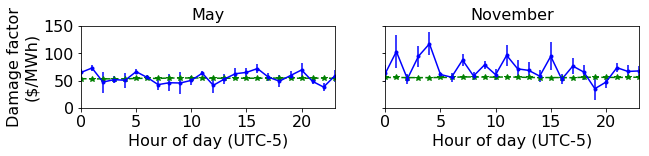

In [17]:
pres_plot(all_dfs, ('PJM', 'FossilOnly'))

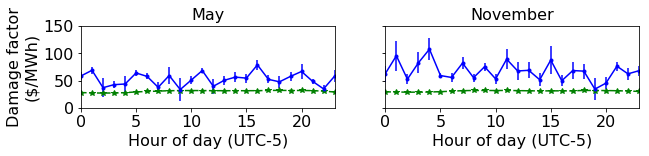

In [18]:
pres_plot(all_dfs, ('PJM', 'FossilPlus'))

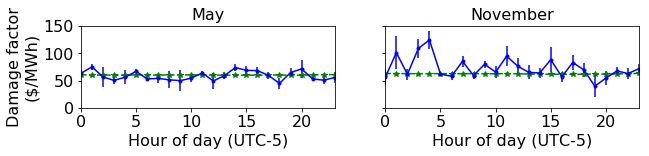

In [19]:
pres_plot(all_dfs, ('RFC', 'FossilOnly'))

## Stats for 2017

### Helpers 

In [20]:
# Mean percent error
def get_mpe(df1, df2):
    return 100 * ((df1-df2)/df2).mean()

# Mean absolute percent error
def get_mape(df1, df2):
    return 100 * (abs((df1-df2)/df2)).mean()

### Restrict to 2017

In [21]:
all_dfs_2017 = {}
for key in all_dfs.keys():
    df = all_dfs[key]
    idx = df.index.names
    df = df.reset_index().query('year==2017').set_index(idx)
    all_dfs_2017[key] = df

### Average vs. marginal 

In [22]:
avg_mar_stats = {}
for region in ['PJM', 'RFC']:
    for fuel_type in ['FossilOnly', 'FossilPlus']:
        if region == 'RFC' and fuel_type == 'FossilPlus': 
            continue
        marg = all_dfs_2017[('MEF', region, fuel_type, 'MonthTOD')][LABELS_FULL]
        avg = all_dfs_2017[('AEF', region, fuel_type, 'MonthTOD')][LABELS_FULL]
        avg_mar_stats[('MPE', region, fuel_type)] = get_mpe(avg, marg)
        avg_mar_stats[('MAPE', region, fuel_type)] = get_mape(avg, marg)
pd.DataFrame(avg_mar_stats).round(0).astype(int)

MAPE                              MPE                      
                    PJM                   RFC        PJM                   RFC
             FossilOnly FossilPlus FossilOnly FossilOnly FossilPlus FossilOnly
co2_dam               9         35         12          7        -35         12
co2_kg                9         35         12          7        -35         12
nox_dam_ap2          95        107        483        -52        -14        425
nox_dam_eas          52         73         60         -1        -60          1
nox_kg               61         49         87         23        -28        -10
pm25_dam_ap2         14         40         18          0        -40         -1
pm25_dam_eas         17         33         23         12        -32         17
pm25_kg              23         31         31         18        -28         24
so2_dam_ap2          90        121         59         14        -15         -5
so2_dam_eas         110        160        108         36       -134         52
so2_kg              208         87        138        136        -40        -35
dam_eas              91         47         26         67        -45          0
dam_ap2              66         53         41         30        -52        -27

### RFC vs. PJM 

In [23]:
pjm_rfc_stats = {}
for kind in ['AEF', 'MEF']:
    pjm = all_dfs_2017[(kind, 'PJM', 'FossilOnly', 'MonthTOD')][LABELS_FULL]
    rfc = all_dfs_2017[(kind, 'RFC', 'FossilOnly', 'MonthTOD')][LABELS_FULL]
    pjm_rfc_stats[(kind, 'MPE')] = get_mpe(rfc, pjm)
    pjm_rfc_stats[(kind, 'MAPE')] = get_mape(rfc, pjm)
pd.DataFrame(pjm_rfc_stats).round(0).astype(int)

AEF      MEF    
             MAPE MPE MAPE MPE
co2_dam         7   7    5   3
co2_kg          7   7    5   3
nox_dam_ap2    25  25   42  21
nox_dam_eas    30  30   33  20
nox_kg         11  11   28  12
pm25_dam_ap2   19  19   26  25
pm25_dam_eas   33  33   32  31
pm25_kg        32  32   33  32
so2_dam_ap2    11  11   34  14
so2_dam_eas    18  18   37  17
so2_kg         13  13   39  18
dam_eas        15  15   98  94
dam_ap2        11  11   27  20

In [24]:
# Highlighted in main text
pd.DataFrame(pjm_rfc_stats).round(0).astype(int).loc['dam_ap2', 'MEF']

MAPE    27
MPE     20
Name: dam_ap2, dtype: int64

### PJM vs. PJM+RE 

In [25]:
fossil_fplus_stats = {}
for kind in ['AEF', 'MEF']:
    fossil = all_dfs_2017[(kind, 'PJM', 'FossilOnly', 'MonthTOD')][LABELS_FULL]
    fplus = all_dfs_2017[(kind, 'PJM', 'FossilPlus', 'MonthTOD')][LABELS_FULL]
    fossil_fplus_stats[(kind, 'MPE')] = get_mpe(fplus, fossil)
    fossil_fplus_stats[(kind, 'MAPE')] = get_mape(fplus, fossil)
pd.DataFrame(fossil_fplus_stats).round(0).astype(int)

AEF      MEF    
             MAPE MPE MAPE MPE
co2_dam        42 -42    5  -3
co2_kg         42 -42    5  -3
nox_dam_ap2    42 -42   19   1
nox_dam_eas    42 -42    9  -3
nox_kg         42 -42   10  -3
pm25_dam_ap2   42 -42    5  -3
pm25_dam_eas   42 -42    5  -3
pm25_kg        42 -42    5  -3
so2_dam_ap2    42 -42   14  -7
so2_dam_eas    42 -42   14  -5
so2_kg         42 -42   16  -8
dam_eas        42 -42   15 -13
dam_ap2        42 -42    9  -6

In [26]:
# Highlighted in main text
pd.DataFrame(fossil_fplus_stats).round(0).astype(int).loc['dam_ap2', 'MEF']

MAPE    9
MPE    -6
Name: dam_ap2, dtype: int64

### Within-month variation

Variation from monthly means of month TOD factors

In [27]:
mtod_var_stats = {}
for kind in ['AEF', 'MEF']:
    for region in ['PJM', 'RFC']:
        for fuel_type in ['FossilOnly', 'FossilPlus']:
            if region == 'RFC' and fuel_type == 'FossilPlus': 
                    continue 
            df = all_dfs_2017[(kind, region, fuel_type, 'MonthTOD')][LABELS_FULL]

            # Get monthly means and put in same format as monthly TOD factors
            month_means = df.groupby([df.index.get_level_values('year'), df.index.get_level_values('month')]).mean()
            month_means['hour'] = 0
            month_means.set_index([month_means.index, 'hour'], inplace=True)
            month_means = month_means.reindex(df.index).ffill()

            # Calculate MAPE. Note that MPE is always 0 by definition.
            pes = 100 * (df - month_means) / month_means
            monthly_mape = abs(pes).groupby(
                [pes.index.get_level_values('year'), pes.index.get_level_values('month')]).mean()
            
            get_min_max = lambda d: d.apply(lambda x: '{} to {}'.format(
                int(x.min().round(0)), int(x.max().round(0))))
            mtod_var_stats[(kind, region, fuel_type, 'MAPE')] = get_min_max(monthly_mape)
pd.DataFrame(mtod_var_stats)

AEF                              MEF                      
                    PJM                   RFC        PJM                   RFC
             FossilOnly FossilPlus FossilOnly FossilOnly FossilPlus FossilOnly
                   MAPE       MAPE       MAPE       MAPE       MAPE       MAPE
co2_dam          1 to 1     2 to 5     1 to 2     3 to 8    3 to 10     3 to 8
co2_kg           1 to 1     2 to 5     1 to 2     3 to 8    3 to 10     3 to 8
nox_dam_ap2      1 to 8    3 to 14     1 to 5   23 to 60   26 to 57   23 to 51
nox_dam_eas      1 to 4     2 to 9     0 to 2   23 to 41   26 to 46   20 to 38
nox_kg           1 to 3     1 to 8     0 to 3   21 to 36   24 to 41   18 to 35
pm25_dam_ap2     0 to 2     2 to 8     0 to 3   10 to 14   10 to 16   10 to 21
pm25_dam_eas     0 to 1     2 to 6     1 to 2    7 to 21    9 to 21    8 to 23
pm25_kg          1 to 2     2 to 6     1 to 2    6 to 27    9 to 27    9 to 28
so2_dam_ap2     2 to 11    3 to 15     1 to 7  27 to 273  32 to 347  26 to 112
so2_dam_eas     2 to 10    3 to 15     1 to 6  25 to 188  30 to 219   26 to 86
so2_kg          2 to 10    3 to 15     1 to 7  25 to 186  30 to 216   26 to 86
dam_eas          0 to 2     2 to 7     1 to 1   10 to 63   14 to 68   10 to 35
dam_ap2          1 to 3     2 to 9     0 to 2  13 to 100  16 to 114   12 to 55

In [28]:
# Highlighted in main text
mtod_var_stats[('MEF', 'PJM', 'FossilOnly', 'MAPE')]

co2_dam            3 to 8
co2_kg             3 to 8
nox_dam_ap2      23 to 60
nox_dam_eas      23 to 41
nox_kg           21 to 36
pm25_dam_ap2     10 to 14
pm25_dam_eas      7 to 21
pm25_kg           6 to 27
so2_dam_ap2     27 to 273
so2_dam_eas     25 to 188
so2_kg          25 to 186
dam_eas          10 to 63
dam_ap2         13 to 100
dtype: object

#### Maximum variation

In [29]:
mtod_var_stats = {}
for kind in ['AEF', 'MEF']:
    for region in ['PJM', 'RFC']:
        for fuel_type in ['FossilOnly', 'FossilPlus']:
            if region == 'RFC' and fuel_type == 'FossilPlus': 
                    continue 
            df = all_dfs_2017[(kind, region, fuel_type, 'MonthTOD')][LABELS_FULL]

            # Get monthly means and put in same format as monthly TOD factors
            month_means = df.groupby([df.index.get_level_values('year'), df.index.get_level_values('month')]).mean()
            month_means['hour'] = 0
            month_means.set_index([month_means.index, 'hour'], inplace=True)
            month_means = month_means.reindex(df.index).ffill()

            # Calculate MAPE. Note that MPE is always 0 by definition.
            pes = 100 * (df - month_means) / month_means
            monthly_mape = abs(pes).groupby(
                [pes.index.get_level_values('year'), pes.index.get_level_values('month')]).max()
            
            get_min_max = lambda d: d.apply(lambda x: '{} to {}'.format(
                int(x.min().round(0)), int(x.max().round(0))))
            mtod_var_stats[(kind, region, fuel_type, 'MAPE')] = get_min_max(monthly_mape)
pd.DataFrame(mtod_var_stats)

AEF                               MEF               \
                    PJM                   RFC         PJM                
             FossilOnly FossilPlus FossilOnly  FossilOnly   FossilPlus   
                   MAPE       MAPE       MAPE        MAPE         MAPE   
co2_dam          1 to 3    4 to 10     1 to 4    11 to 26     12 to 31   
co2_kg           1 to 3    4 to 10     1 to 4    11 to 26     12 to 31   
nox_dam_ap2     2 to 15    6 to 22     1 to 9   59 to 375    66 to 269   
nox_dam_eas      2 to 7    4 to 17     1 to 5   58 to 145    64 to 139   
nox_kg           2 to 7    3 to 15     1 to 6   55 to 114    61 to 114   
pm25_dam_ap2     1 to 6    4 to 16     1 to 5    24 to 48     27 to 65   
pm25_dam_eas     1 to 3    3 to 13     3 to 5    19 to 55     24 to 60   
pm25_kg          2 to 4    3 to 12     3 to 6    12 to 67     21 to 71   
so2_dam_ap2     4 to 23    8 to 32    3 to 17  84 to 1217  100 to 1827   
so2_dam_eas     4 to 20    8 to 29    3 to 14   89 to 767   86 to 1057   
so2_kg          4 to 21    8 to 30    3 to 15   94 to 761   90 to 1043   
dam_eas          1 to 5    5 to 15     1 to 3   29 to 255    43 to 318   
dam_ap2          1 to 8    5 to 18     1 to 5   32 to 458    49 to 609   

                         
                    RFC  
             FossilOnly  
                   MAPE  
co2_dam        13 to 27  
co2_kg         13 to 27  
nox_dam_ap2   66 to 227  
nox_dam_eas   49 to 117  
nox_kg        43 to 123  
pm25_dam_ap2   22 to 93  
pm25_dam_eas   31 to 86  
pm25_kg       34 to 106  
so2_dam_ap2   86 to 716  
so2_dam_eas   78 to 511  
so2_kg        74 to 508  
dam_eas       23 to 203  
dam_ap2       28 to 340